<a href="https://colab.research.google.com/github/GiulioCMSanto/HDSIdent/blob/master/notebooks/SISO%20Systems/Segmentation/numerical_conditioning_siso_laguerre_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Conditioning: SISO Laguerre Approach

[HDSIdent: Historical Data Segmentation for System Identification](https://github.com/GiulioCMSanto/HDSIdent)

This notebook explores how to obtain intervals suitable for system identification through a numerical conditioning Laguerre Filter approach, considering Single-Input Single-Output systems.

**How to reference this work?**

[SANTO, G. C. M. Data Mining Techniques Applied to Historical Data of Industrial Processes 
as a Tool to Find Time Intervals Suitable for System Identification. Masters dissertation 
– Polytechnic School of the University of São Paulo, São Paulo, Brasil, 2020. 
DOI: 10.13140/RG.2.2.13295.46240](https://www.researchgate.net/publication/347511108_Data_Mining_Techniques_Applied_to_Historical_Data_of_Industrial_Processes_as_a_Tool_to_Find_Time_Intervals_Suitable_for_System_Identification?channel=doi&linkId=5fdf5293a6fdccdcb8e856c4&showFulltext=true)




**About the Method**

The method here presented is produced based on the following works:
```
PERETZKI, D. et al. Data mining of historic data for process identification.
In: Proceedings of the 2011 AIChE Annual Meeting, p. 1027–1033, 2011.

BITTENCOURT, A. C. et al. An algorithm for finding process identification
intervals from normal operating data. Processes, v. 3, p. 357–383, 2015.

RIBEIRO, A. H.; AGUIRRE, L. A. Selecting transients automatically for the
identification of models for an oil well. IFAC-PapersOnLine, v. 48, n. 6, p.
154–158, 2015.

ARENGAS, D.; KROLL, A. A Search Method for Selecting Informative Data in Predominantly
Stationary Historical Records for Multivariable System Identification.
In: Proceedings of the 21st International Conference on System Theory,
Control and Computing (ICSTCC). Sinaia, Romenia: IEEE, 2017a. p. 100–105.

ARENGAS, D.; KROLL, A. Searching for informative intervals in predominantly stationary
data records to support system identification. In: Proceedings of the XXVI International
Conference on Information, Communication and Automation Technologies (ICAT). Sarajevo,
Bosnia-Herzegovina: IEEE, 2017b.
```

Related works are the following:
```
SHARDT, Y. A. W.; SHAH, S. L. Segmentation Methods for Model Identification from
Historical Process Data. In: Proceedings of the 19th World Congress. Cape Town,
South Africa: IFAC, 2014. p. 2836–2841.
  
PATEL, A. Data Mining of Process Data in Mutlivariable Systems.
Degree project in electrical engineering — Royal Institute of Technology,
Stockholm, Sweden, 2016.
```

**About the [Dataset](https://github.com/GiulioCMSanto/HDSIdent/tree/master/data/water_tank)**

The dataset here adopted was produced through simulation in the dissertation (SANTO, G. C. M., 2020). The dataset is created based on the work in (WANG et al., 2018). The transfer functions adopted in the simulation were directly extracted from (WANG et al., 2018 apud YU et al., 2011), as well as the simulation idea, where similar signals were produced.

**References**:

```
SANTO, G. C. M. Data Mining Techniques Applied to Historical Data of Industrial Processes 
as a Tool to Find Time Intervals Suitable for System Identification. Masters dissertation 
– Polytechnic School of the University of São Paulo, São Paulo, Brasil, 2020. 
DOI: 10.13140/RG.2.2.13295.46240.

WANG, J. et al. Searching historical data segments for process identification
in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.

YU, Z. et al. Performance assessment of pid control loops subject to setpoint
changes. Journal of Process Control, v. 21, n. 8, p. 1164–1171, 2011.
````

In [ ]:
!git clone https://github.com/GiulioCMSanto/HDSIdent.git

fatal: destination path 'HDSIdent' already exists and is not an empty directory.


In [ ]:
# Change into the directory for install
%cd HDSIdent/

/content/HDSIdent/HDSIdent/HDSIdent/HDSIdent


In [ ]:
!python setup.py install

python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

plotly.io.renderers.default = 'colab'

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
from HDSIdent.data_treatment.data_preprocessing import Preprocessing
from HDSIdent.initial_intervals.exponentially_weighted import ExponentiallyWeighted
from HDSIdent.initial_intervals.bandpass_filter import BandpassFilter
from HDSIdent.initial_intervals.sliding_window import SlidingWindow

from HDSIdent.segmentation_methods.mimo_segmentation import MIMOSegmentation
from HDSIdent.model_structures.ar_structure import ARStructure
from HDSIdent.model_structures.arx_structure import ARXStructure
from HDSIdent.model_structures.laguerre_filter import LaguerreStructure
 

## **1. Read Data**

In [ ]:
mv_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_mv.csv'
sp_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_sp.csv'
y_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_y.csv'

In [ ]:
mv = pd.read_csv(mv_url, error_bad_lines=False, header=None)
sp = pd.read_csv(sp_url, error_bad_lines=False, header=None)
y = pd.read_csv(y_url, error_bad_lines=False, header=None)

## **2. Data Preprocessing**

In [ ]:
pp = Preprocessing(
        scaler='MinMaxScaler',
        feature_range=(-0.5,0.5),
        k=100);

In [ ]:
X, y = pp.fit_transform(X=np.concatenate([sp, mv],axis=1),y=y)

In [ ]:
sp = X[:,0]
mv = X[:,1]
y = y.values

In [ ]:
df = pd.DataFrame()
df['SP'] = np.squeeze(sp)
df['MV'] = np.squeeze(mv)
df['Y'] = np.squeeze(y)

In [ ]:
df.head()

,SP,MV,Y
0,-0.1,0.003182,-0.109338
1,-0.1,-0.000913,-0.106037
2,-0.1,-0.009513,-0.099186
3,-0.1,-0.012116,-0.097125
4,-0.1,-0.008668,-0.099873


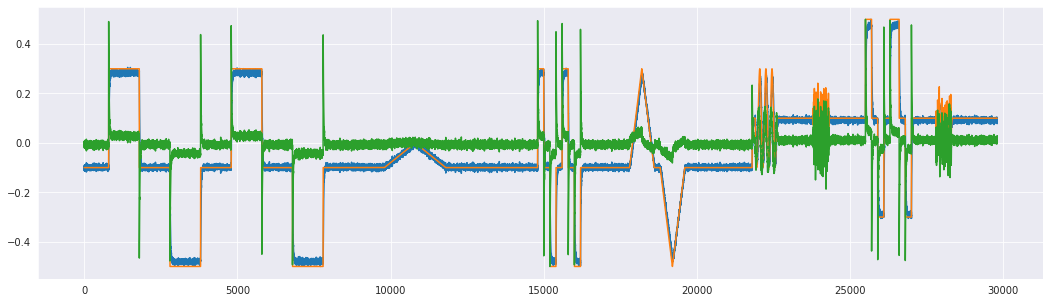

In [ ]:
plt.figure(figsize=(18,5));
plt.plot(y);
plt.plot(sp);
plt.plot(mv);

## **3. Stationary Approach**

### **3.1 Case 1: num_previous_indexes = 0**

#### **3.1.1 Compute Potential Intervals**

In [ ]:
EW = ExponentiallyWeighted(
          forgetting_fact_v = np.array([0.006,0.006]),
          forgetting_fact_u = np.array([0.006,0.006]),
          H_v = [0.003,0.003],
          num_previous_indexes=0,
          min_input_coupling=1,
          min_output_coupling=1,
          verbose=0,
          n_jobs=-1
        )

EW.fit(X=df[['SP']], y=df[['Y']]);

In [ ]:
EW.unified_intervals.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

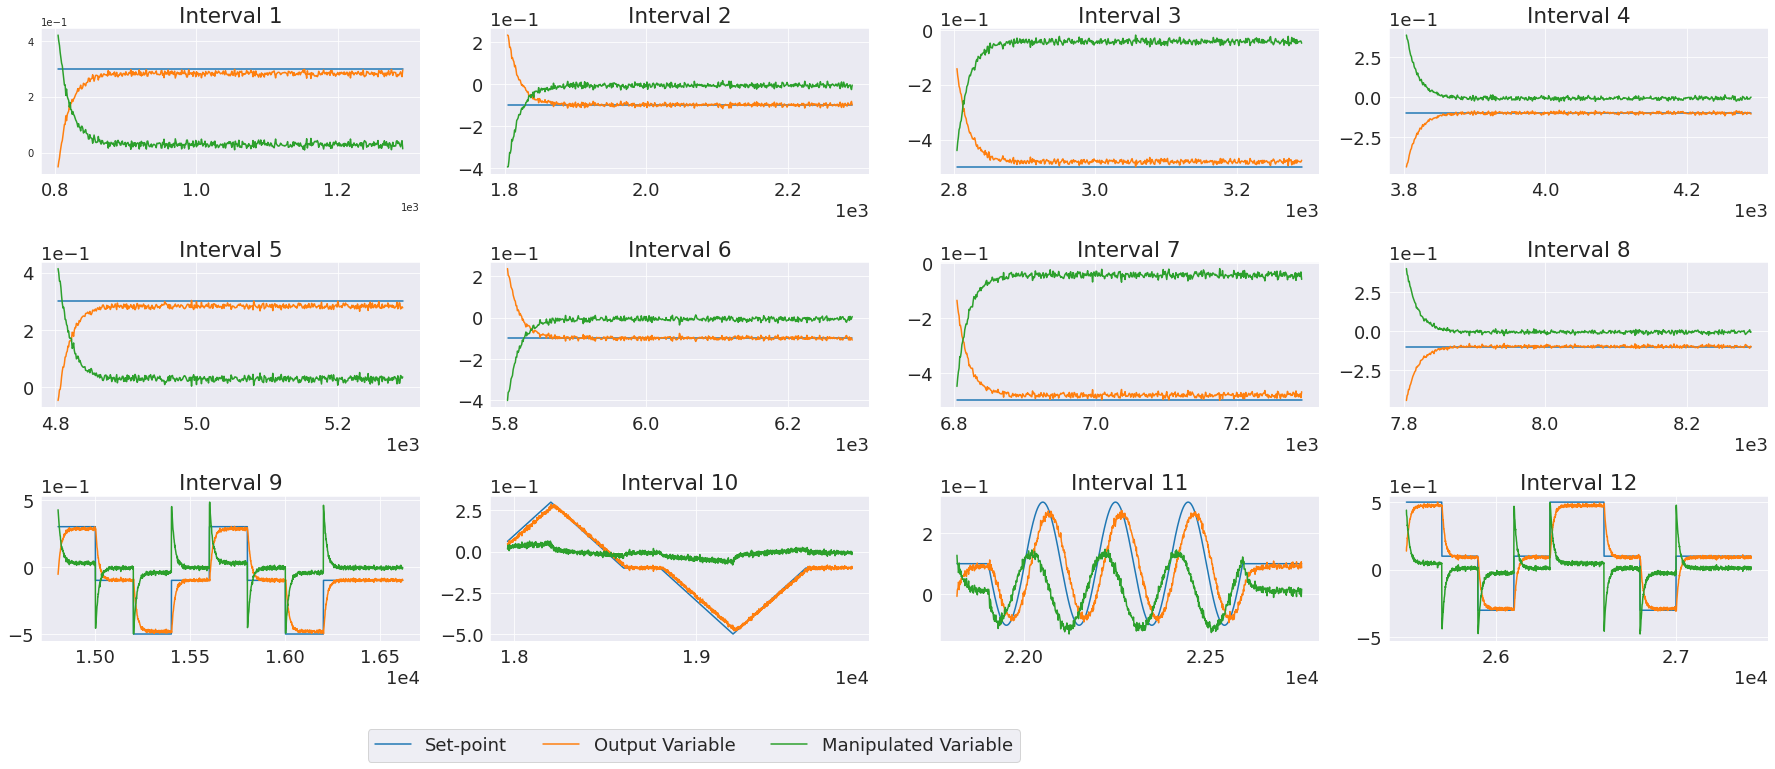

In [ ]:
plt.figure(figsize=(25,10));

plt.subplot(3,4,1);
plt.rc('font', size=18);
plt.plot(df[['SP']].iloc[EW.unified_intervals[0]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[0]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[0]], label="Manipulated Variable");
plt.title("Interval 1");
plt.xticks(fontsize=18);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);
    
plt.subplot(3,4,2);
plt.plot(df[['SP']].iloc[EW.unified_intervals[1]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[1]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[1]], label="Manipulated Variable");
plt.title("Interval 2");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,3);
plt.plot(df[['SP']].iloc[EW.unified_intervals[2]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[2]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[2]], label="Manipulated Variable");
plt.title("Interval 3");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,4);
plt.plot(df[['SP']].iloc[EW.unified_intervals[3]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[3]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[3]], label="Manipulated Variable");
plt.title("Interval 4");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,5);
plt.plot(df[['SP']].iloc[EW.unified_intervals[4]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[4]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[4]], label="Manipulated Variable");
plt.title("Interval 5");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,6);
plt.plot(df[['SP']].iloc[EW.unified_intervals[5]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[5]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[5]], label="Manipulated Variable");
plt.title("Interval 6");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,7);
plt.plot(df[['SP']].iloc[EW.unified_intervals[6]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[6]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[6]], label="Manipulated Variable");
plt.title("Interval 7");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,8);
plt.plot(df[['SP']].iloc[EW.unified_intervals[7]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[7]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[7]], label="Manipulated Variable");
plt.title("Interval 8");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,9);
plt.plot(df[['SP']].iloc[EW.unified_intervals[8]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[8]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[8]], label="Manipulated Variable");
plt.title("Interval 9");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,10);
plt.plot(df[['SP']].iloc[EW.unified_intervals[9]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[9]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[9]], label="Manipulated Variable");
plt.title("Interval 10");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,11);
plt.plot(df[['SP']].iloc[EW.unified_intervals[10]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[10]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[10]], label="Manipulated Variable");
plt.title("Interval 11");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,12);
plt.plot(df[['SP']].iloc[EW.unified_intervals[11]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[11]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[11]], label="Manipulated Variable");
plt.title("Interval 12");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.tight_layout();

leg = plt.legend(bbox_to_anchor=(-0.95, -0.55),
                 fancybox=True,
                 shadow=False, 
                 ncol=9);

#### **3.1.2 Apply Numerical Conditioning Method With Laguerre Filter**

In [ ]:
LG = LaguerreStructure(
        Nb=10,
        p=0.92,
        delay=10,
        cc_alpha=0.95,
        initial_intervals=EW.unified_intervals,
        efr_type='type_2',
        sv_thr=0.5,
        n_jobs = -1,
        verbose = 0
      )

#### **3.1.3 Verify Condition Number and Effective Rank with set-point**

In [ ]:
start = time()
LG.fit(X=sp,y=y);
end = time()

In [ ]:
print("Execution Time: {}".format(end-start))

Execution Time: 7.99200177192688


In [ ]:
pd.DataFrame(LG.miso_ranks).T

,output_0
segment_1,{'input_0': 1}
segment_0,{'input_0': 1}
segment_3,{'input_0': 1}
segment_2,{'input_0': 1}
segment_5,{'input_0': 1}
segment_4,{'input_0': 1}
segment_7,{'input_0': 1}
segment_6,{'input_0': 1}
segment_8,{'input_0': 9}
segment_9,{'input_0': 5}


In [ ]:
pd.DataFrame(LG.cond_num_dict).T

,output_0
segment_0,{'input_0': 1.9963732309457766e+27}
segment_1,{'input_0': 1.246522598815122e+18}
segment_3,{'input_0': 1.246522598815122e+18}
segment_2,{'input_0': 7.071235445196038e+17}
segment_4,{'input_0': 1.9963732309457766e+27}
segment_5,{'input_0': 1.246522598815122e+18}
segment_6,{'input_0': 7.071235445196038e+17}
segment_7,{'input_0': 1.246522598815122e+18}
segment_8,{'input_0': 6182.46051704893}
segment_10,{'input_0': 355915.6208173135}


#### **3.1.4 Verify Condition Number and Effective Rank with manipulated variable**

In [ ]:
start = time()
LG.fit(X=mv,y=y);
end = time()

In [ ]:
print("Execution Time: {}".format(end-start))

Execution Time: 8.03621530532837


In [ ]:
pd.DataFrame(LG.miso_ranks).T

,output_0
segment_0,{'input_0': 7}
segment_1,{'input_0': 7}
segment_2,{'input_0': 7}
segment_3,{'input_0': 7}
segment_4,{'input_0': 7}
segment_5,{'input_0': 7}
segment_6,{'input_0': 7}
segment_7,{'input_0': 7}
segment_9,{'input_0': 3}
segment_10,{'input_0': 7}


In [ ]:
pd.DataFrame(LG.cond_num_dict).T

,output_0
segment_0,{'input_0': 105166.05779321825}
segment_1,{'input_0': 93210.80446435342}
segment_2,{'input_0': 129583.23475681662}
segment_3,{'input_0': 84663.40511462065}
segment_4,{'input_0': 102631.38532258695}
segment_6,{'input_0': 113596.26267561168}
segment_7,{'input_0': 99313.93579593851}
segment_5,{'input_0': 96220.65597143042}
segment_8,{'input_0': 837.1267229641095}
segment_9,{'input_0': 2496.167786930727}


#### **3.1.5 Estimate Parameters and Computing the Chi-squered test**

In [ ]:
pd.DataFrame(LG.chi_squared_dict).T

,output_0
segment_0,{'input_0': 28.134049499591637}
segment_1,{'input_0': 22.48876420434015}
segment_3,{'input_0': 29.51495481683186}
segment_2,{'input_0': 35.66038986865697}
segment_4,{'input_0': 28.070020275682303}
segment_6,{'input_0': 35.42828285352542}
segment_7,{'input_0': 29.558977295274808}
segment_5,{'input_0': 22.55011837761428}
segment_8,{'input_0': 32.62667094815057}
segment_9,{'input_0': 146.0881795536032}


### **3.2 Case 2: num_previous_indexes = 20**

In [ ]:
EW = ExponentiallyWeighted(
        forgetting_fact_v = np.array([0.006,0.006]),
        forgetting_fact_u = np.array([0.006,0.006]),
        H_v = [0.003,0.003],
        num_previous_indexes=20,
        min_input_coupling=1,
        min_output_coupling=1,
        verbose=0,
        n_jobs=-1
      )

EW.fit(X=df[['SP']], y=df[['Y']]);

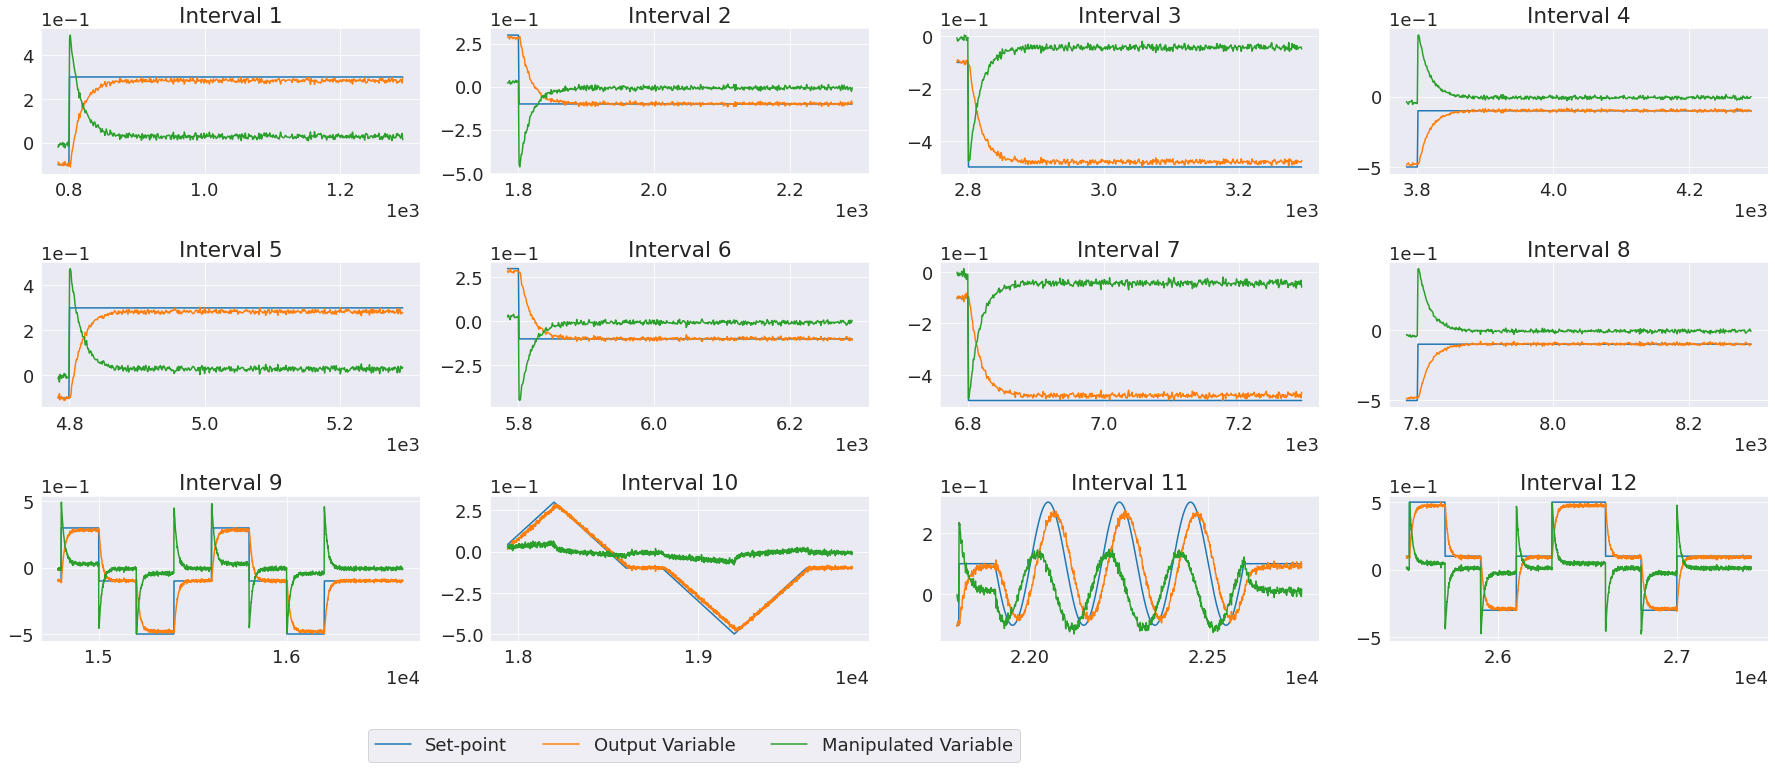

In [ ]:
plt.figure(figsize=(25,10));

plt.subplot(3,4,1);
plt.rc('font', size=18);
plt.plot(df[['SP']].iloc[EW.unified_intervals[0]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[0]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[0]], label="Manipulated Variable");
plt.title("Interval 1");
plt.xticks(fontsize=18);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);
    
plt.subplot(3,4,2);
plt.plot(df[['SP']].iloc[EW.unified_intervals[1]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[1]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[1]], label="Manipulated Variable");
plt.title("Interval 2");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,3);
plt.plot(df[['SP']].iloc[EW.unified_intervals[2]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[2]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[2]], label="Manipulated Variable");
plt.title("Interval 3");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,4);
plt.plot(df[['SP']].iloc[EW.unified_intervals[3]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[3]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[3]], label="Manipulated Variable");
plt.title("Interval 4");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,5);
plt.plot(df[['SP']].iloc[EW.unified_intervals[4]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[4]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[4]], label="Manipulated Variable");
plt.title("Interval 5");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,6);
plt.plot(df[['SP']].iloc[EW.unified_intervals[5]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[5]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[5]], label="Manipulated Variable");
plt.title("Interval 6");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,7);
plt.plot(df[['SP']].iloc[EW.unified_intervals[6]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[6]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[6]], label="Manipulated Variable");
plt.title("Interval 7");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,8);
plt.plot(df[['SP']].iloc[EW.unified_intervals[7]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[7]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[7]], label="Manipulated Variable");
plt.title("Interval 8");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,9);
plt.plot(df[['SP']].iloc[EW.unified_intervals[8]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[8]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[8]], label="Manipulated Variable");
plt.title("Interval 9");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,10);
plt.plot(df[['SP']].iloc[EW.unified_intervals[9]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[9]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[9]], label="Manipulated Variable");
plt.title("Interval 10");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,11);
plt.plot(df[['SP']].iloc[EW.unified_intervals[10]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[10]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[10]], label="Manipulated Variable");
plt.title("Interval 11");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.subplot(3,4,12);
plt.plot(df[['SP']].iloc[EW.unified_intervals[11]], label="Set-point");
plt.plot(df[['Y']].iloc[EW.unified_intervals[11]], label="Output Variable");
plt.plot(df[['MV']].iloc[EW.unified_intervals[11]], label="Manipulated Variable");
plt.title("Interval 12");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tick_params(axis="x",direction="in", pad=8);
plt.locator_params(axis='y', nbins=4);
plt.locator_params(axis='x', nbins=4);
plt.rc('font', size=18);

plt.tight_layout();

leg = plt.legend(bbox_to_anchor=(-0.95, -0.55),
                 fancybox=True,
                 shadow=False, 
                 ncol=9);

#### **3.2.1 Apply Numerical Conditioning Method With Laguerre Filter**

In [ ]:
LG = LaguerreStructure(
        Nb=10,
        p=0.92,
        delay=5,
        cc_alpha=0.05,
        initial_intervals=EW.unified_intervals,
        efr_type='type_2',
        sv_thr=1,
        n_jobs = -1,
        verbose = 0
      )

#### **3.1.2 Verify Condition Number and Effective Rank with set-point**

In [ ]:
start = time()
LG.fit(X=sp,y=y);
end = time()

In [ ]:
print("Execution Time: {}".format(end-start))

Execution Time: 7.804789781570435


In [ ]:
pd.DataFrame(LG.miso_ranks).T

,output_0
segment_0,{'input_0': 7}
segment_1,{'input_0': 6}
segment_2,{'input_0': 7}
segment_3,{'input_0': 7}
segment_4,{'input_0': 7}
segment_5,{'input_0': 6}
segment_6,{'input_0': 7}
segment_7,{'input_0': 7}
segment_9,{'input_0': 4}
segment_8,{'input_0': 9}


In [ ]:
pd.DataFrame(LG.cond_num_dict).T

,output_0
segment_1,{'input_0': 4255.250460341141}
segment_2,{'input_0': 34648.41373540748}
segment_3,{'input_0': 13934.932555192365}
segment_4,{'input_0': 11183.28946019082}
segment_5,{'input_0': 4255.250460341141}
segment_6,{'input_0': 34648.41373540748}
segment_0,{'input_0': 11183.28946019082}
segment_7,{'input_0': 13934.932555192365}
segment_9,{'input_0': 27899097.213287413}
segment_8,{'input_0': 4704.355020963012}


In [ ]:
pd.DataFrame(LG.miso_correlations).T

,output_0
segment_0,{'input_0': 3.859635520024193}
segment_1,{'input_0': 3.8605613576952362}
segment_3,{'input_0': 3.8674063186660232}
segment_2,{'input_0': 3.871429094409292}
segment_4,{'input_0': 3.869144043918307}
segment_6,{'input_0': 3.8655151140805692}
segment_5,{'input_0': 3.867896666465911}
segment_7,{'input_0': 3.862510035315409}
segment_9,{'input_0': 5.300152340936431}
segment_8,{'input_0': 5.029504489592242}


#### **3.2.3 Estimating Parameters and Computing the Chi-squered test**

In [ ]:
pd.DataFrame(LG.chi_squared_dict).T

,output_0
segment_0,{'input_0': 104.1234698194978}
segment_1,{'input_0': 34.28355991142729}
segment_3,{'input_0': 10.126400603085324}
segment_2,{'input_0': 128.68599768874668}
segment_4,{'input_0': 99.84502902696254}
segment_5,{'input_0': 36.43300620662085}
segment_6,{'input_0': 135.15494777717606}
segment_7,{'input_0': 9.559410359481289}
segment_8,{'input_0': 110.83319257436214}
segment_10,{'input_0': 101.63433030393469}


#### **3.2.4 Apply Entire Algorithm in a Single step**

In [ ]:
MS = MIMOSegmentation(
        model_structure=[LG],
        segmentation_method=['method1'],
        parameters_dict={'Laguerre':{'chi2_p_value_thr':0.01, 
                                      'cond_thr':15000, 
                                      'min_input_coupling':1,
                                      'min_output_coupling':1}
                          },
        segmentation_type='stationary',
        n_jobs=-1,
        verbose=0
        );

In [ ]:
start=time()
MS.fit(X=df[['MV']],y=df[['Y']],sp=df[['SP']]);
end=time()

In [ ]:
print("Execution Time for Each Interval: {}".format((end-start)/len(EW.unified_intervals.keys())))

Execution Time for Each Interval: 1.2075571020444233


In [ ]:
MS.sucessed_intervals['method1']['Laguerre'].keys()

dict_keys(['segment_0', 'segment_1', 'segment_4', 'segment_5', 'segment_8', 'segment_10', 'segment_11'])

In [ ]:
print(chi2.ppf(1-0.01,10))

23.209251158954356


## **4. Incremental Approach**

In [ ]:
sw = SlidingWindow(
            window_size=50, 
            H_v = [0.003,0.003], 
            min_input_coupling=1,
            min_output_coupling=1,
            num_previous_indexes=0,
            min_interval_length=None,
            n_jobs=-1, 
            verbose=0
          )

In [ ]:
start = time()
sw.fit(X=df[['SP']], y=df[['Y']])
end = time()

In [ ]:
sw.unified_intervals.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [ ]:
LG = LaguerreStructure(
        Nb=7,
        p=0.8,
        initial_intervals=sw.unified_intervals,
        n_jobs = -1,
        verbose = 0
        )

In [ ]:
MS_2 = MIMOSegmentation(model_structure=[LG],
                        segmentation_method=['method1'],
                        parameters_dict={'Laguerre':{'chi2_p_value_thr':0.01, 
                                                     'cond_thr':15000, 
                                                     'min_input_coupling':1,
                                                     'min_output_coupling':1}
                                         },
                        segmentation_type='incremental',
                        increment_size=100,
                        interval_max_length=600,
                        n_jobs=-1,
                        verbose=1);

In [ ]:
MS_2.fit(X=df[['MV']], y=df[['Y']], sp=df[['SP']])

Fitting Laguerre Model Structure...
Laguerre Structure fit finished! 


Beginning Incremental Segmentation... 

Making Initial Segmentation... 

Incrementing Segment segment_1 for Model Structure Laguerre using method1
Current Index: 1838
Current Interval Length: 62
Condition Number: defaultdict(<class 'dict'>, {'Y': {'MV': 1304.4320827089755}})
chi-squared Test: defaultdict(<class 'dict'>, {'Y': {'MV': 32.96667865099139}})
Effective Ranks: defaultdict(<class 'dict'>, {})
Scalar Cross-correlation: defaultdict(<class 'dict'>, {}) 

Current Index: 1938
Current Interval Length: 162
Condition Number: defaultdict(<class 'dict'>, {'Y': {'MV': 1396.5489369986244}})
chi-squared Test: defaultdict(<class 'dict'>, {'Y': {'MV': 11.268676722787355}})
Effective Ranks: defaultdict(<class 'dict'>, {})
Scalar Cross-correlation: defaultdict(<class 'dict'>, {}) 

Incrementing Segment segment_2 for Model Structure Laguerre using method1
Current Index: 2838
Current Interval Length: 62
Condition Number: def

In [ ]:
chi2.ppf(1-0.01,7)

18.475306906582357

In [ ]:
MS_2.sucessed_intervals['method1']['Laguerre'].keys()

dict_keys(['segment_1', 'segment_2', 'segment_3', 'segment_4', 'segment_5', 'segment_6', 'segment_7', 'segment_9', 'segment_10', 'segment_11', 'segment_12', 'segment_13', 'segment_14', 'segment_15', 'segment_16', 'segment_23', 'segment_25', 'segment_26', 'segment_27', 'segment_28', 'segment_29'])

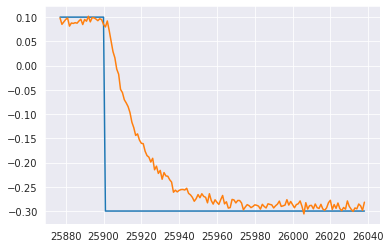

In [ ]:
plt.plot(MS_2.sucessed_intervals['method1']['Laguerre']['segment_25'],
         sp[MS_2.sucessed_intervals['method1']['Laguerre']['segment_25']])
plt.plot(MS_2.sucessed_intervals['method1']['Laguerre']['segment_25'],
         y[MS_2.sucessed_intervals['method1']['Laguerre']['segment_25']])

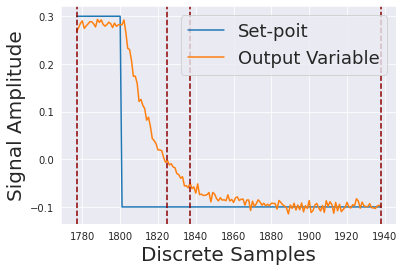

In [ ]:
plt.plot(MS_2.sucessed_intervals['method1']['Laguerre']['segment_1'],
         sp[MS_2.sucessed_intervals['method1']['Laguerre']['segment_1']],label='Set-poit')
plt.plot(MS_2.sucessed_intervals['method1']['Laguerre']['segment_1'],
         y[MS_2.sucessed_intervals['method1']['Laguerre']['segment_1']], label='Output Variable')

plt.axvline(min(sw.sequential_indicating_sequences['input']['SP'][1]),linestyle='--', color='darkred');
plt.axvline(max(sw.sequential_indicating_sequences['input']['SP'][1]),linestyle='--', color='darkred');
plt.axvline(max(sw.sequential_indicating_sequences['output']['Y'][1]),linestyle='--', color='darkred');


plt.axvline(MS_2._indexes_of_failure['method1']['Laguerre']['segment_1'],
            linestyle='--', color='darkred');

plt.xlabel("Discrete Samples", fontsize=20);
plt.ylabel("Signal Amplitude", fontsize=20);
plt.legend(fontsize=18);

In [ ]:
print("SP variance in T1: {}".format(np.array(sw.var_arr['SP'])[sw.sequential_indicating_sequences['input']['SP'][1]][0]))
print("SP variance in T2: {}".format(np.array(sw.var_arr['SP'])[sw.sequential_indicating_sequences['input']['SP'][1]][-1]))
print("SP variance in T3: {}".format(np.array(sw.var_arr['SP'])[sw.unified_intervals[1]][-1]))
print("Y variance in T1: {}".format(np.array(sw.var_arr['Y'])[sw.sequential_indicating_sequences['input']['SP'][1]][0]))
print("Y variance in T2: {}".format(np.array(sw.var_arr['Y'])[sw.sequential_indicating_sequences['input']['SP'][1]][-1]))
print("Y variance in T3: {}".format(np.array(sw.var_arr['Y'])[sw.unified_intervals[1]][-1]))

SP variance in T1: 0.0031359999999999986
SP variance in T2: 0.0031359999999999995
SP variance in T3: 1.925929944387236e-34
Y variance in T1: 3.4273160563406716e-05
Y variance in T2: 0.012728623514975662
Y variance in T3: 0.003149694326170879


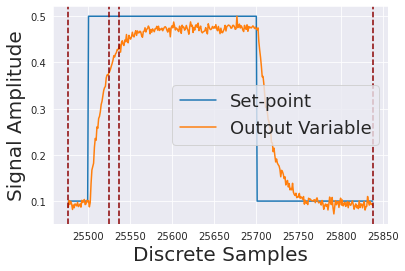

In [ ]:
plt.plot(MS_2.sucessed_intervals['method1']['Laguerre']['segment_23'],
         sp[MS_2.sucessed_intervals['method1']['Laguerre']['segment_23']], label='Set-point');
plt.plot(MS_2.sucessed_intervals['method1']['Laguerre']['segment_23'],
         y[MS_2.sucessed_intervals['method1']['Laguerre']['segment_23']], label='Output Variable');

plt.axvline(min(sw.sequential_indicating_sequences['input']['SP'][25]),linestyle='--', color='darkred');
plt.axvline(max(sw.sequential_indicating_sequences['input']['SP'][25]),linestyle='--', color='darkred');
plt.axvline(max(sw.sequential_indicating_sequences['output']['Y'][23]),linestyle='--', color='darkred');

plt.axvline(max(MS_2.sucessed_intervals['method1']['Laguerre']['segment_23']),
            linestyle='--', color='darkred');

plt.xlabel("Discrete Samples", fontsize=20);
plt.ylabel("Signal Amplitude", fontsize=20);
plt.legend(fontsize=18);

## **5. Impact of Laguerre Filter Parameters**

In [ ]:
EW = ExponentiallyWeighted(
        forgetting_fact_v = np.array([0.006,0.006]),
        forgetting_fact_u = np.array([0.006,0.006]),
        H_v = [0.003,0.003],
        num_previous_indexes=20,
        min_input_coupling=1,
        min_output_coupling=1,
        verbose=0,
        n_jobs=-1);

In [ ]:
EW.fit(X=df[['SP']],y=df[['Y']]);

In [ ]:
pole_arr = np.arange(0.1,1.02,0.02)[::-1]
order_arr = np.array(range(2,13))[::-1]

pole_grid, order_grid = np.meshgrid(pole_arr, order_arr)
num_intervals_mtx = np.zeros((pole_grid.shape[0],pole_grid.shape[1]))
len_intervals_mtx = np.zeros((pole_grid.shape[0],pole_grid.shape[1]))

counter = 0
start = time()
for idx_1 in range(pole_grid.shape[0]):
    for idx_2 in range(pole_grid.shape[1]):
        
        counter+=1
        if counter%50==0:
            end = time()
            print("Iteration {}/{} -> Time: {} s".format(counter,pole_grid.shape[0]*pole_grid.shape[1],round(end-start,2)))
            start = time()
    
        pole = pole_grid[idx_1,idx_2]
        order = order_grid[idx_1,idx_2]
        
        LG = LaguerreStructure(Nb=order,
                               p=pole,
                               initial_intervals=EW.unified_intervals,
                               n_jobs = -1,
                               verbose = 0)

        
        MS = MIMOSegmentation(
                model_structure=[LG],
                segmentation_method=['method1'],
                parameters_dict={'Laguerre':{'chi2_p_value_thr':0.01, 
                                             'cond_thr':20000, 
                                             'min_input_coupling':1,
                                             'min_output_coupling':1}
                                 },
                segmentation_type='stationary',
                n_jobs=-1,
                verbose=0);
        
        MS.fit(X=df[['SP']],y=df[['Y']], sp=df[['SP']]);

        num_intervals_mtx[idx_1,idx_2] = len(MS.sucessed_intervals['method1']['Laguerre'].keys())

/content/HDSIdent/HDSIdent/model_structures/laguerre_filter.py:88: RuntimeWarning:

invalid value encountered in sqrt



Iteration 50/506 -> Time: 804.88 s
Iteration 100/506 -> Time: 751.03 s
Iteration 150/506 -> Time: 675.4 s
Iteration 200/506 -> Time: 604.39 s
Iteration 250/506 -> Time: 526.59 s
Iteration 300/506 -> Time: 457.83 s
Iteration 350/506 -> Time: 378.86 s


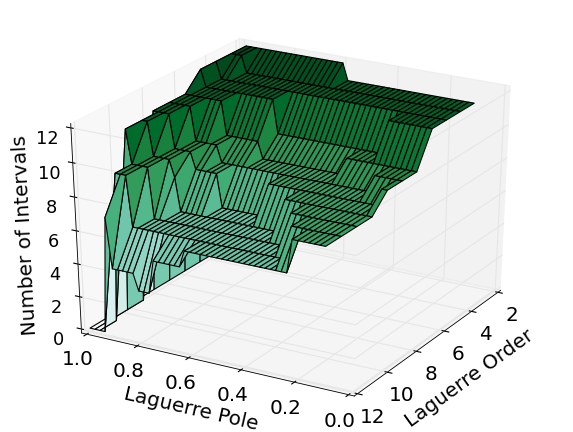

In [ ]:
from mpl_toolkits import mplot3d
plt.style.use('classic')

fig = plt.figure(figsize=(9,6.5),facecolor="white")
ax = plt.axes(projection='3d')

ax.plot_surface(pole_grid,order_grid,num_intervals_mtx,rstride=1, cstride=1,cmap='BuGn');

ax.view_init(28, 120);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
ax.zaxis.set_tick_params(labelsize=16);

plt.xlabel("Laguerre Pole", fontsize=18,labelpad=12);
plt.ylabel("Laguerre Order", fontsize=18,labelpad=12);

tmp_planes = ax.zaxis._PLANES 
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])


ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Number of Intervals', fontsize=18, rotation=93);

In [ ]:
fig = go.Figure(data =
    go.Contour(
        z=num_intervals_mtx,
        x=np.array(pole_arr), # horizontal axis
        y=np.array(order_arr), # vertical axis,
        zmin=0,
        zmax=12,
        colorscale='bugn',
                contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 26,
                color = 'black',
            )
    )))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title={'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title=r"$\Large \text{Laguerre Filter Pole } \alpha$",
    yaxis_title=r"$\Large \text{Laguerre Filter Order } N_{b}$",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black"
    ),
)

fig['layout']['xaxis']['autorange'] = "reversed"
fig['layout']['yaxis']['autorange'] = "reversed"

fig.show()